In [14]:
#Importa le librerie necessarie per il progetto, come :
# -TensorFlow e Keras per costruire e addestrare il modello, 
# -pandas per manipolare i dati, 
# -numpy per operazioni numeriche, 
# -sklearn per dividere i dati in training e validation, 
# -PIL per manipolare le immagini e 
# -matplotlib per la visualizzazione.
import tensorflow as tf
from tensorflow._api.v2.data import Dataset
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras.src.models import Sequential
from keras.src.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.src.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from keras.src.utils import to_categorical
from PIL import Image
import matplotlib.pyplot as plt
from keras.src.utils import image_dataset_from_directory
import json

In [2]:
# Percorsi ai dataset
train_images_path = 'data/images_training_rev1/images_training_rev1' #le immagini di training
test_images_path = 'data/images_test_rev1/images_test_rev1' #le immagini test
train_labels_path = 'solutions/training_solutions_rev1/training_solutions_rev1.csv' #le etichette csv del training

In [3]:
# Percorsi ai dataset sul portatile
train_images_path = 'C:/Users/AndreaBianchini/Downloads/galaxy-zoo-the-galaxy-challenge/images_training_rev1/images_training_rev1'
test_images_path = 'C:/Users/AndreaBianchini/Downloads/galaxy-zoo-the-galaxy-challenge/images_test_rev1/images_test_rev1'
train_labels_path = 'C:/Users/AndreaBianchini/Downloads/galaxy-zoo-the-galaxy-challenge/training_solutions_rev1/training_solutions_rev1.csv' 

In [4]:
# Caricamento delle etichette
train_labels_df = pd.read_csv(train_labels_path)

In [5]:
# Funzione per creare il dataset tf.data
def load_image(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [64, 64])
    img = img / 255.0  # Normalizzazione
    return img, label

In [6]:
def create_dataset(image_paths, labels):
    dataset = Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000).batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [7]:
# Creazione del DataFrame con i percorsi delle immagini e le etichette
image_paths = [os.path.join(train_images_path, f"{int(img_id)}.jpg") for img_id in train_labels_df['GalaxyID']]
labels = train_labels_df.iloc[:, 1:].values

In [8]:
# Split del dataset in training e validation
image_paths_train, image_paths_val, labels_train, labels_val = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [9]:
# Creazione dei dataset tf.data
train_dataset = create_dataset(image_paths_train, labels_train)
val_dataset = create_dataset(image_paths_val, labels_val)

In [10]:
# Creazione del modello della rete neurale
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(37, activation='sigmoid')  # Utilizziamo sigmoid per una regressione multilabel
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

c:\Users\AndreaBianchini\anaconda3\envs\UFS12DL\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 37)             │         4,773 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,629,925 (6.22 MB)

 Trainable params: 1,629,925 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Callback per l'early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [12]:
# Addestramento del modello
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[early_stopping])

Epoch 1/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 173s 218ms/step - accuracy: 0.5685 - loss: 0.3039 - val_accuracy: 0.5758 - val_loss: 0.2665
Epoch 2/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 165s 214ms/step - accuracy: 0.6012 - loss: 0.2656 - val_accuracy: 0.6502 - val_loss: 0.2590
Epoch 3/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 165s 214ms/step - accuracy: 0.6520 - loss: 0.2597 - val_accuracy: 0.7094 - val_loss: 0.2550
Epoch 4/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 163s 211ms/step - accuracy: 0.6825 - loss: 0.2552 - val_accuracy: 0.6946 - val_loss: 0.2523
Epoch 5/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 166s 215ms/step - accuracy: 0.7004 - loss: 0.2525 - val_accuracy: 0.7032 - val_loss: 0.2507
Epoch 6/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 165s 213ms/step - accuracy: 0.7077 - loss: 0.2506 - val_accuracy: 0.7312 - val_loss: 0.2485
Epoch 7/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 158s 204ms/step - accuracy: 0.7150 - loss: 0.2490 - val_accuracy: 0.7371 - val_loss: 0.2488
Epoch 8/10
770/770 ━━━━━━━━━━━━━━━━━━━━ 128s 165ms/step - accuracy: 0.7228 -

In [13]:
# Salvataggio del modello
model.save('galaxy_model.keras')
print("Modello salvato in 'galaxy_model.keras'")


Modello salvato in 'galaxy_model.keras'


In [15]:
#ipotetico:

'''
# Salvataggio dello storico dell'allenamento
with open('history.json', 'w') as f:
    json.dump(history.history, f)
print("Storico dell'allenamento salvato in 'history.json'")

# Carica lo storico dell'allenamento
with open('history.json', 'r') as f:
    history = json.load(f)
'''

Storico dell'allenamento salvato in 'history.json'


In [ ]:
#Per caricarlo in futuro:
model = tf.keras.models.load_model('galaxy_model.keras')

AttributeError: 'dict' object has no attribute 'history'

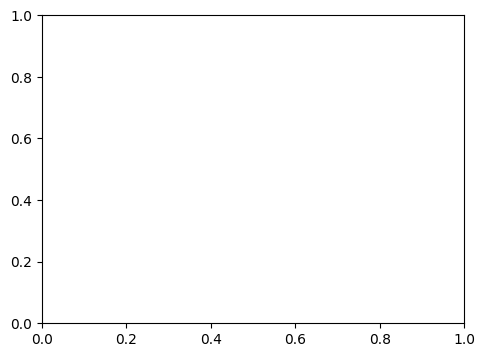

In [16]:
# Plotting training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

AttributeError: 'dict' object has no attribute 'history'

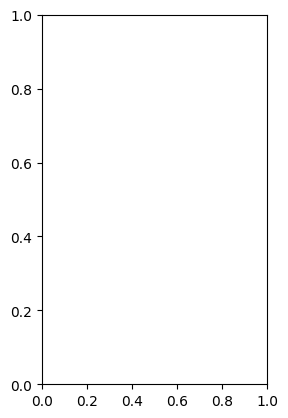

In [17]:
# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Creo una rete neurale convoluzionale (CNN) usando il modello 'Sequential' di Keras.
## La rete è composta da:
- Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)): un livello convoluzionale con 32 filtri, kernel di dimensione 3x3, funzione di attivazione ReLU e input shape di 256x256x3 (dimensioni dell'immagine con 3 canali colore).

- MaxPooling2D((2, 2)): un livello di max pooling con finestra di 2x2 per ridurre le dimensioni spaziali.

- Conv2D(64, (3, 3), activation='relu'): un secondo livello convoluzionale con 64 filtri.

- MaxPooling2D((2, 2)): un altro livello di max pooling.

- Flatten(): appiattisce l'output 3D a 1D per l'ingresso nei livelli densi.

- Dropout(0.5): applica il dropout con un tasso del 50% per prevenire l'overfitting.

- Dense(128, activation='relu'): un livello denso completamente connesso con 128 neuroni e funzione di attivazione ReLU.

- Dense(37, activation='sigmoid'): un livello denso con 37 neuroni e funzione di attivazione sigmoide, utilizzato per la classificazione multilabel.

In [ ]:
# Creazione del modello della rete neurale
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(37, activation='sigmoid')  # Utilizziamo sigmoid per una regressione multilabel
])


#Compila il modello usando l'ottimizzatore Adam, la loss binary_crossentropy e la metrica accuracy.
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Divisione dei dati in training(80%) e validation set(20%)
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [ ]:
print("imploso?")
# Addestramento del modello:
#Addestra il modello sui dati di addestramento per 10 epoche con un batch size di 64, usando il set di validazione per monitorare le prestazioni.
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

In [ ]:
# Caricamento delle immagini di test
test_images, test_image_ids = load_images_from_folder(test_images_path, image_size=(128, 128))

In [ ]:
# Predizione delle etichette per il test set
predictions = model.predict(test_images)


In [ ]:
# Creazione del DataFrame con le predizioni:
#Crea un DataFrame con le predizioni e aggiunge la colonna GalaxyID con gli ID delle immagini di test.
predictions_df = pd.DataFrame(predictions, columns=['Class' + str(i) for i in range(predictions.shape[1])])
predictions_df.insert(0, 'GalaxyID', test_image_ids)


In [ ]:
# Salvataggio delle predizioni in un file CSV
predictions_df.to_csv('galaxies_predictions_new.csv', index=False)

In [ ]:
# Mappatura delle classi alle loro descrizioni
class_descriptions = {
    0: "La galassia appare liscia, senza particolari caratteristiche.",
    1: "La galassia ha caratteristiche visibili o un disco.",
    2: "La galassia è identificata come stella o artefatto.",
    3: "La galassia è vista di taglio.",
    4: "La galassia non è vista di taglio.",
    5: "La galassia ha una barra visibile.",
    6: "La galassia non ha una barra visibile.",
    7: "La galassia ha una struttura a spirale.",
    8: "La galassia non ha una struttura a spirale.",
    9: "La galassia ha una forma rotonda.",
    10: "La galassia ha una forma squadrata.",
    11: "La galassia non ha un rigonfiamento centrale.",
    12: "La galassia ha un disco visibile di taglio.",
    13: "La galassia non ha un disco visibile di taglio.",
    14: "La galassia ha un rigonfiamento centrale arrotondato.",
    15: "La galassia ha un rigonfiamento centrale squadrato.",
    16: "La galassia non ha un rigonfiamento centrale.",
    17: "La galassia ha un braccio a spirale.",
    18: "La galassia ha due bracci a spirale.",
    19: "La galassia ha tre bracci a spirale.",
    20: "La galassia ha quattro bracci a spirale.",
    21: "La galassia ha cinque bracci a spirale.",
    22: "La galassia ha sei bracci a spirale.",
    23: "La galassia ha sette bracci a spirale.",
    24: "La galassia ha otto bracci a spirale.",
    25: "La galassia ha nove bracci a spirale.",
    26: "La galassia ha dieci bracci a spirale.",
    27: "La galassia ha un rigonfiamento centrale arrotondato.",
    28: "La galassia ha un rigonfiamento centrale squadrato.",
    29: "La galassia non ha un rigonfiamento centrale.",
    30: "La galassia ha una struttura ad anello.",
    31: "La galassia non ha una struttura ad anello.",
    32: "La galassia ha una struttura a lente o arco.",
    33: "La galassia non ha una struttura a lente o arco.",
    34: "La galassia è risultata da una fusione.",
    35: "La galassia non è risultata da una fusione.",
    36: "La galassia è sovrapposta con altre galassie o stelle."
}


In [ ]:
# Visualizzazione delle immagini di test con le classificazioni
def display_predictions(images, image_ids, predictions_df, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(min(num_images, len(images))):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"GalaxyID: {image_ids[i]}")
    
        
        # Trova la classificazione con la probabilità più alta
        galaxy_id = image_ids[i]
        prediction_row = predictions_df[predictions_df['GalaxyID'] == galaxy_id]
        prediction_row = prediction_row.drop(columns=['GalaxyID']).values[0]
        top_class = np.argmax(prediction_row)
        top_class_prob = prediction_row[top_class]
        
        description = class_descriptions[top_class]
        
        plt.xlabel(f"Class: {top_class}, Prob: {top_class_prob:.2f}")
        plt.ylabel(description)
        plt.axis("off")

    plt.show()

In [ ]:
# Visualizzazione delle immagini di test con le predizioni
display_predictions(test_images, test_image_ids, predictions_df, num_images=10)

In [ ]:
# Creazione del file di testo con le descrizioni
with open('galaxies_descriptions.txt', 'w') as file:
    for i in range(len(test_images)):
        galaxy_id = test_image_ids[i]
        prediction_row = predictions_df[predictions_df['GalaxyID'] == galaxy_id]
        prediction_row = prediction_row.drop(columns=['GalaxyID']).values[0]
        top_class = np.argmax(prediction_row)
        top_class_prob = prediction_row[top_class]
        description = class_descriptions[top_class]
        file.write(f"GalaxyID: {galaxy_id}, Class: {top_class}, Prob: {top_class_prob:.2f}, Description: {description}\n")

print("File 'galaxies_descriptions.txt' creato con successo.")